## ETH Model deployment

This notebook will import new data to feed into the trained LSTM model and produce csvs of close price and predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime as dt
from copy import deepcopy as dc
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from api_keys import coinapi_key

2023-09-16 11:48:48.873353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&&time_start=2023-01-02T00:00:00&limit=10000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-01-02T00:00:00.0000000Z', 'time_period_end': '2023-01-03T00:00:00.0000000Z', 'time_open': '2023-01-02T00:00:30.8560000Z', 'time_close': '2023-01-02T23:59:58.0220000Z', 'price_open': 1200.2, 'price_high': 1222.9, 'price_low': 1193, 'price_close': 1214.5, 'volume_traded': 8513.89427594, 'trades_count': 5484}, {'time_period_start': '2023-01-03T00:00:00.0000000Z', 'time_period_end': '2023-01-04T00:00:00.0000000Z', 'time_open': '2023-01-03T00:00:06.0750000Z', 'time_close': '2023-01-03T23:59:54.5080000Z', 'price_open': 1214.5, 'price_high': 1219.5, 'price_low': 1204.9, 'price_close': 1214.5, 'volume_traded': 5296.58034653, 'trades_count': 5857}, {'time_period_start': '2023-01-04T00:00:00.0000000Z', 'time_period_end': '2023-01-05T00:00:00.0000000Z', 'time_open': '2023-01-04T00:01:16.7410000Z', 'time_close': '2023-01-04T23:59:20.8760000Z', 'price_open': 1214.3, 'price_high': 1270.2, 'price_low': 1212.6, 'price_close': 1256.5, 'volume_traded': 15768.16265551, 'trade

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:00:30.8560000Z,2023-01-02T23:59:58.0220000Z,1200.2,1222.9,1193.0,1214.5,8513.894276,5484
1,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:00:06.0750000Z,2023-01-03T23:59:54.5080000Z,1214.5,1219.5,1204.9,1214.5,5296.580347,5857
2,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:01:16.7410000Z,2023-01-04T23:59:20.8760000Z,1214.3,1270.2,1212.6,1256.5,15768.162656,7823
3,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:01:08.8800000Z,2023-01-05T23:59:39.8980000Z,1256.5,1259.5,1242.2,1250.6,7160.411004,6075
4,2023-01-06T00:00:00.0000000Z,2023-01-07T00:00:00.0000000Z,2023-01-06T00:00:04.9020000Z,2023-01-06T23:59:06.5040000Z,1250.9,1276.0,1235.6,1269.2,9404.155065,7289


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
# data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data

,Close
Date,
2023-01-02,1214.5
2023-01-03,1214.5
2023-01-04,1256.5
2023-01-05,1250.6
2023-01-06,1269.2
...,...
2023-09-12,1593.3
2023-09-13,1608.1
2023-09-14,1627.1


In [5]:
close = data['Close']

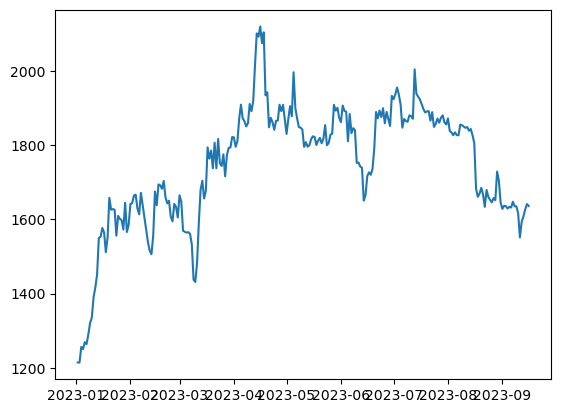

In [6]:
#plot historical eth price
plt.plot(close)

In [7]:
# build 6 day lookback windows for lstm prediction
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

lookback = 6
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6)
Date,,,,,,,
2023-01-08,1289.6,1263.9,1269.2,1250.6,1256.5,1214.5,1214.5
2023-01-09,1320.5,1289.6,1263.9,1269.2,1250.6,1256.5,1214.5
2023-01-10,1335.5,1320.5,1289.6,1263.9,1269.2,1250.6,1256.5
2023-01-11,1390.2,1335.5,1320.5,1289.6,1263.9,1269.2,1250.6
2023-01-12,1416.6,1390.2,1335.5,1320.5,1289.6,1263.9,1269.2
...,...,...,...,...,...,...,...
2023-09-12,1593.3,1551.7,1616.8,1635.3,1636.0,1647.9,1632.2
2023-09-13,1608.1,1593.3,1551.7,1616.8,1635.3,1636.0,1647.9
2023-09-14,1627.1,1608.1,1593.3,1551.7,1616.8,1635.3,1636.0


In [8]:
#create array of dates for plotting from new index (needs to account for dropped dates that
# are abosrbed into the first lookback window. 

dates = shifted_df.index
dates.shape

(248,)

In [9]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

#Log transform df to scale data for prediction
shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np_int)

log_transformed_data.shape

(248, 7)

In [10]:
#Load trained model
model = load_model("H5_Files/eth_7_day.h5")

2023-09-16 11:48:57.029717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = log_transformed_data[-1].reshape((1, 7, 1))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

#Build date range   
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
#'predictions' contains forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 30ms/step
[7.3758235, 7.375732, 7.376861, 7.3787603, 7.3808284, 7.382651, 7.383102]
2023-09-17
2023-09-18
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23


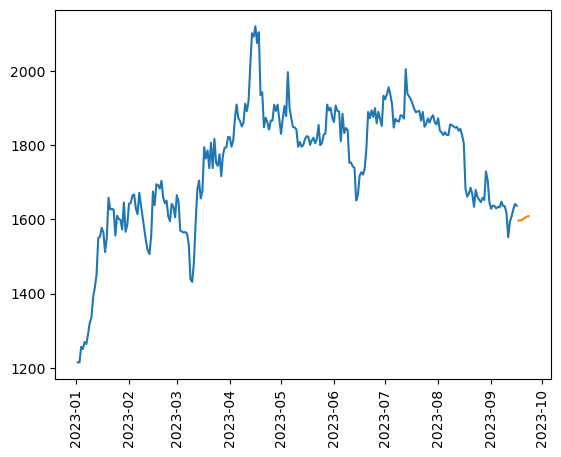

In [12]:
plt.plot(close)
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)

plt.show()

In [13]:
# build output into a df for graphing in js. Merge new predictions with full import from api.

df = pd.DataFrame({"Date": dates, "observed":close[lookback:]})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,future_prediction
Date,,
2023-01-08,1289.6,NaN
2023-01-09,1320.5,NaN
2023-01-10,1335.5,NaN
2023-01-11,1390.2,NaN
2023-01-12,1416.6,NaN


In [14]:
past_future_df.tail()

,observed,future_prediction
Date,,
2023-09-19,NaN,1598.564209
2023-09-20,NaN,1601.603027
2023-09-21,NaN,1604.918579
2023-09-22,NaN,1607.846313
2023-09-23,NaN,1608.571655


In [22]:
#Pull in old CSV to extract previous predictions to plot against new ones.
past_df = pd.read_csv('output/eth_model.csv')

past_df

,Date,observed,future_prediction
0,2023-01-08,1289.6,NaN
1,2023-01-09,1320.5,NaN
2,2023-01-10,1335.5,NaN
3,2023-01-11,1390.2,NaN
4,2023-01-12,1416.6,NaN
...,...,...,...
250,2023-09-19,NaN,1598.5642
251,2023-09-20,NaN,1601.6030
252,2023-09-21,NaN,1604.9186
253,2023-09-22,NaN,1607.8463


In [25]:
# #Pull in old CSV to extract previous predictions to plot against new ones.
# past_df = pd.read_csv('output/eth_model.csv')

# past_df = past_df[["Date", "future_prediction"]]
# past_df.set_index('Date', inplace=True)


# past_df = past_df.rename(columns={"future_prediction":"past_pred"})

# df_combined = pd.merge(past_future_df,past_df, how='outer', left_index=True, right_index=True)

# df_combined.tail(20)

,observed,future_prediction,past_pred
Date,,,
2023-09-04,NaN,NaN,NaN
2023-09-05,NaN,NaN,NaN
2023-09-06,NaN,NaN,NaN
2023-09-07,NaN,NaN,NaN
2023-09-08,NaN,NaN,NaN
2023-09-09,NaN,NaN,NaN
2023-09-10,NaN,NaN,NaN
2023-09-11,NaN,NaN,NaN
2023-09-12,NaN,NaN,NaN


In [26]:
df_combined= past_future_df.copy()

In [27]:
past_future_df.to_csv('output/eth_model.csv') 

In [17]:
df_combined.to_csv('output/eth_model_hist.csv') 